# ⭐Imports


In [1]:
from processing_functions import *
%matplotlib inline

TensorFlow Version:  2.1.0


---

# ⭐ Building Classifier

## 🔵 Step 1: Preprocess Data (Create Dataset)

1. Preprocess Signal & Background Data
2. Concatenate & Shuffle signal/background data
3. Convert to tf.data.Dataset object



## 🔵 Step 2: Create Batches

Batches: number of events with which you update trained parameters once

- `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

- `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Theory guide: https://www.tensorflow.org/guide/data_performance#prefetching

## 🔵 ML Notes
### 🔴 Compile the Model


- **Optimizer** -- Determines how the model is updated based on the data it sees and its loss function
- **Loss Function** -- Measures how accurate the model is during training
- **Metrics** -- Monitors the training and testing steps. 

### 🔴 Fit the Model

## Notes

**Early Stopping**: <br /> 
Stop training when there is no improvement in the validation loss for 5 consecutive epochs or when metric gain is less than 0.001

**Save Best**: <br />
Saves the best model

## Notes
#### Activation Function (non normalised)
- **Relu**: sometimes results in all predictions being 0 
- **tanh**: solves this issue; accuracy (n = 1): 73
- **softsign**: solves and performs similarly to tanh
- **elu**: solves and performs slightly better than tanh

#### Activation Function (log)
- **softsign**: only softsign works. accuracy: 67

#### Activation Function (normal)
- Nothing has worked

### Other hyperparameters
- kernel_size = 2, 3, 5, 7 perform best (very similarly to one another)
- padding = 'valid', 'same' result in very similar performance
- filters: tried small (8 in all) to large (256 in all) and they perform similarly to one another. 

Create Dataset

In [2]:
# # Import, Preprocess, Create Dataset
# start = time.time()
# data_s = create_dataset_CNN('dataset_signal.dat')
# data_b = create_dataset_CNN('dataset_background.dat')
# end = time.time()
# print('Time taken: {:.2f} mins'.format((end-start)/60))

# # Save Datasets
# pd.DataFrame(data_s).to_csv('data_s_norm_csv')
# pd.DataFrame(data_b).to_csv('data_b_norm_csv')

Load 

In [3]:
# Load Previously saved data
# MAIN
data_s = np.array(pd.read_csv('data_s_csv').iloc[:, 1:])
data_b = np.array(pd.read_csv('data_b_csv').iloc[:, 1:])

# # LOG
# data_s = np.array(pd.read_csv('data_s_log_csv').iloc[:, 1:])
# data_b = np.array(pd.read_csv('data_b__log_csv').iloc[:, 1:])

# # NORMAL
# data_s = np.array(pd.read_csv('data_s_normal_csv').iloc[:, 1:])
# data_b = np.array(pd.read_csv('data_b_normal_csv').iloc[:, 1:])



ML Preprocess

Total Events: 29449
Total Labels: 29449
Shape:  (29449, 40, 40, 1)
 
Train:  (20525, 40, 40, 1) (20525,)
Val:  (4506, 40, 40, 1) (4506,)
Test:  (4418, 40, 40, 1) (4418,)
 
<TensorSliceDataset shapes: ((40, 40, 1), ()), types: (tf.float64, tf.float64)>
<TensorSliceDataset shapes: ((40, 40, 1), ()), types: (tf.float64, tf.float64)>
<TensorSliceDataset shapes: ((40, 40, 1), ()), types: (tf.float64, tf.float64)>
<PrefetchDataset shapes: ((64, 40, 40, 1), (64,)), types: (tf.int64, tf.int64)>

train, val, test:  320 70 69


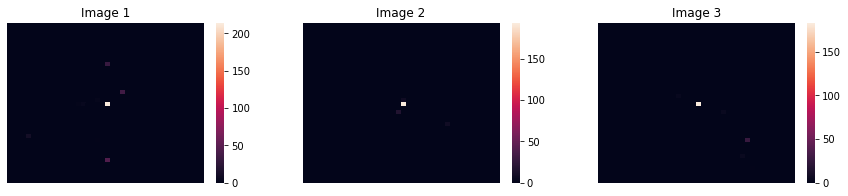

In [4]:
batch_size=64
train_batches, val_batches, test_batches, num_of_batches_train, num_of_batches_val, num_of_batches_test = preprocess_ML_tf(data_s, data_b, batch_size=batch_size)

#### 🔴 Confusion Matrix & ROC Curve (unseen test data)

Note ROC: For relu activation function (i.e. model outputs two probabilities per event, [P(background), P(signal)]

In [5]:
model0 = tf.keras.models.load_model('model_recent.h5')
model1 = tf.keras.models.load_model('model_tanh_7360.h5')
model2 = tf.keras.models.load_model('model_relu_7570.h5')

models = [model0, model1, model2]

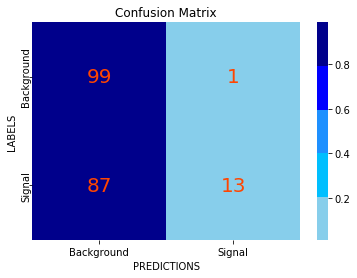

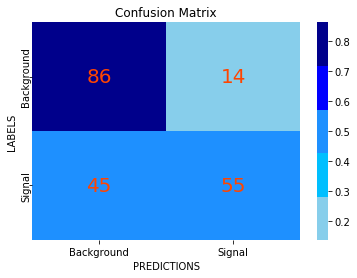

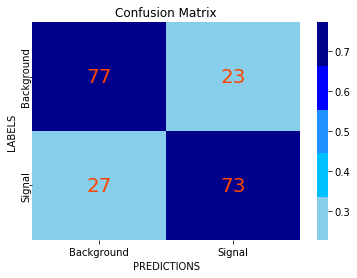

In [6]:
cmx_tf(models, test_batches, num_of_batches_test)

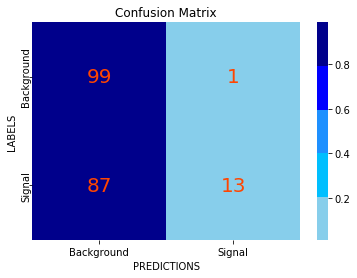

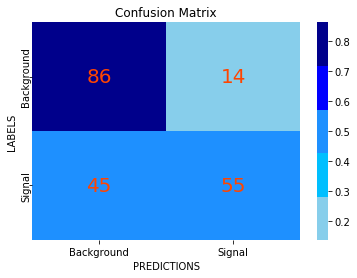

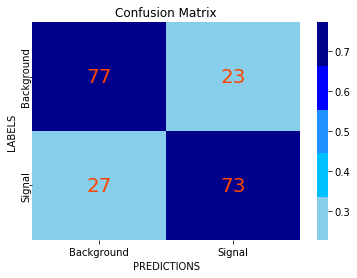

In [7]:
cmx_tf(models, test_batches, num_of_batches_test)

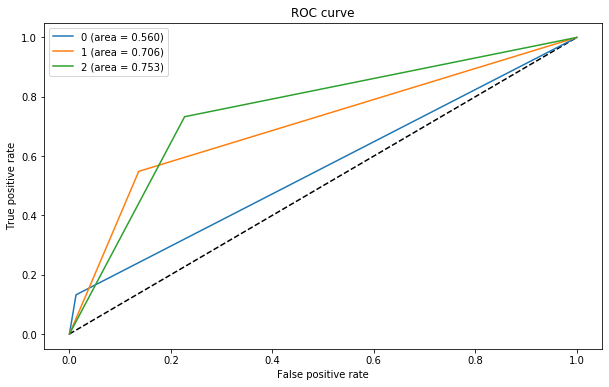

In [8]:
ROC3_tf(model0, model1, model2, test_batches, num_of_batches_test)

---

---

---

---

---

---

---

---

# 🔵 Build the Model

### 🔴 Learning Curve (underfitting test)
Determine whether a larger dataset could improve performance

In [9]:
# learning_curve(train_batches, val_batches, test_batches, num_of_batches_train, num_of_batches_val)

### 🔴 Train Model (with Hyperparameter Tuning)

In [10]:
input_shape=(40, 40, 1)
kernel_size = 2
padding='valid'
activation = 'tanh'

activations = ['elu', 'exponential', 'hard_sigmoid', 'linear', 'relu', 'selu', 'sigmoid', 'softmax', 'softplus', 'softsign', 'tanh']
kernels = [1, 3, 5, 7, 9, 11]
paddings = ['valid', 'same']
paddings = ['valid']
filters = [8, 16, 64, 256, 512]

for padding in paddings:

    model = tf.keras.Sequential([
              tf.keras.Input(shape=input_shape),
              tf.keras.layers.Conv2D(16, kernel_size=kernel_size, padding=padding, activation=activation),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Conv2D(32, kernel_size=kernel_size, padding=padding, activation=activation),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Conv2D(64, kernel_size=kernel_size, padding=padding, activation=activation),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(128, activation=activation),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.Dense(2, activation = 'softmax')
    ])

    #model.summary()

    # Compile Model
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.Precision()])

    
    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta = 0.001)
    save_best = tf.keras.callbacks.ModelCheckpoint('./model_recent.h5', monitor='loss', save_best_only=True)

    print('\n\n', activation, '\n')

    # Fit model to training data
    EPOCHS = 5

    history = model.fit(train_batches, 
              epochs=EPOCHS,
              callbacks= [early_stopping, save_best],
              validation_data=val_batches, 
              verbose=1
              )
    
    loss, accuracy = model.evaluate(test_batches, verbose=0)

    print('\nLoss on the Test Set: {:,.3f}'.format(loss))
    print('Accuracy on the Test Set: {:.1%}'.format(accuracy))



 tanh 

Train for 320 steps, validate for 70 steps
Epoch 1/5
  1/320 [..............................] - ETA: 1:06WARNING:tensorflow:Early stopping conditioned on metric `loss` which is not available. Available metrics are: 


ValueError: Shapes (64, 2) and (64, 1) are incompatible

#### 🔴 Model-Complexity Graph 

How performance changes with epochs

In [ ]:
# model_complexity_graph(history)

#### 🔴 Evaluate Model

In [ ]:
model = tf.keras.models.load_model('model_relu_7570.h5')
#model.summary()

loss, accuracy = model.evaluate(test_batches, verbose=0)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.1%}'.format(accuracy))

#### 🔴 Visualise Predictions

In [ ]:
visualise_preds(model, test_batches)